<H1>Challenge: Evaluate and Iterate Regression Model</H1><br><br>
This project uses the New York State crime statistics data for 2013, taken from <a href='https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls'>the FBI UCR repository</a>.<br><br>

This challenge is a progression of <a href='https://github.com/AlliedToasters/NYCrimeData/blob/master/My_First_LinReg.ipynb'>my first linear regression model</a>. I evaluate the model with a variety of techniques and, based on the results of the evaluation, will try to improve it.<br><br>
<H2>First Evaluation: Cross Validation</H2><br><br>
Considering our number of data is in the low hundreds, I'll try cross validation with ten folds. I'll randomly sample the population, train the model on three folds, and see how it does on the fourth. I'll repeat this process four times, once for each fold.<br><br>
Building the features:

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
%matplotlib inline
sns.set_context(font_scale=2)

In [72]:
df = pd.read_excel('clean_crime_data.xlsx')

In [73]:
df['PC_per_capita'], df['Burg_per_capita'] = df['Property crime']/df.Population, df['Burglary']/df.Population
df['LT_per_capita'], df['MVT_per_capita'] = df['Larceny-theft']/df.Population, df['Motor vehicle theft']/df.Population

df['cbrt_PCpc'] = np.cbrt(df['PC_per_capita'])

In [74]:
df['VCpc'] = df['Violent crime']/df.Population #Aggregated property crime per capita
df['frthrt_VCpc'] = np.power(df['VCpc'], (1/4)) #Take the fourth root to get nice linear correlation to target var

#Binary feature, tags if zero violent crime in city
df['no_VC'] = np.where((df['Violent crime'] == 0), 1, 0)

#Binary feature, tags if any murder reported in city
df['has_Murd'] = np.where((df['Murder and nonnegligent manslaughter'] > 0), 1, 0)

#Binary feature, tags if New York City. Obviously a unique data point.
df['is_NYC'] = np.where((df.City == 'New York'), 1, 0)

In [75]:
df['known_arson'] = np.where((df['Arson3'].notnull()), df['Arson3'], 0)
df['has_arson'] = np.where((df['Arson3'] > 0), 1, 0)
ars = df[df['has_arson'] == 1]

ars_regr = linear_model.LinearRegression()
murds = ars['Murder and nonnegligent manslaughter'].values.reshape(-1, 1)
arsn = ars.known_arson.values.reshape(-1, 1)
ars_regr.fit(murds, arsn) #fit data
ars_regr.score(murds, arsn)
df['pred_arson'] = ars_regr.predict(df['Murder and nonnegligent manslaughter'].values.reshape(-1, 1)) #predict
df['pred_arson'] = np.where((df['pred_arson'] < 0), 0, 1) #When regression gives negative values, set to zero
df['est_arson'] = np.where((df['has_arson'] == 1), df['Arson3'], df['pred_arson']) 
#use real numbers where available.

df['est_arson_per_capita'] = df['est_arson']/df.Population #per capita
df['frthrt_ars_pc'] = np.power((df['est_arson_per_capita']), (1/4)) #And take a root transform to make things tidy

I'll write a function for performing the cross-validation which will return an R-squared value for each fold:

In [76]:
def cross_validate(data, train, target, folds=10):
    """Takes a pd.DataFrame, list of training variables, and a list of target variables.
    Optional keyword argument folds specifies desired number of folds/holdout groups.
    Does cross validation test with n number of folds and returns a list of Rsquared values
    equal in length to the number of folds. Uses smf.ols for regression statistics.
    """
    n = int(folds) #n tracks desired number of folds
    folds = dict() #will track selected indices
    inds = pd.Series(data.index) #use series type for .sample() method
    selected = [] #will track indices already selected
    mod = len(data)%n #handle remainder of len/folds
    group_size = int((len(data)-mod)/n) #ensures proper integer group size
    for fold in range(1, n+1):  #This loop selects random samples for each group
        if fold == n:
            group_size += mod #add remainder to last group
        sample = inds[~inds.index.isin(selected)].sample(group_size) #excluded indices already selected
        selected += list(sample)
        name = 'sample_{}'.format(fold)
        folds[name] = sample
    scores = [] #This will be output
    for sample in folds:
        learn = data[~data.index.isin(folds[sample])][train] 
        targ = data[~data.index.isin(folds[sample])][target] #fit regression on all indices but fold
        test_in = data[data.index.isin(folds[sample])][train]
        test_targ = data[data.index.isin(folds[sample])][target] #holdout group for scoring
        reg = linear_model.LinearRegression()
        reg.fit(learn, targ) #fit model
        scores += [reg.score(test_in, test_targ)] #score model and add to 'scores'
    return scores
    

In [77]:
data = df[df.City != "New York"]
scores = cross_validate(data, ['frthrt_VCpc', 'no_VC', 'has_Murd', 'frthrt_ars_pc'], 'cbrt_PCpc', folds=5)
print(scores)
scr = pd.Series(scores)
scr.describe()

[0.45970642478525015, 0.41429826353261345, 0.32958340552007048, 0.42830173078989564, 0.57016355898482196]


count    5.000000
mean     0.440411
std      0.087062
min      0.329583
25%      0.414298
50%      0.428302
75%      0.459706
max      0.570164
dtype: float64

So we see the Rsquared score vary quite a bit with a mean at .38 and standard deviation of .20. Next I build a similar function that uses smf.ols instead, allowing us to get some more regression statistics.

In [78]:
def cross_validate_ols(data, train, target, folds=10):
    """Takes a pd.DataFrame, list of training variables, and a list of target variables.
    Optional keyword argument folds specifies desired number of folds/holdout groups.
    Does cross validation test with n number of folds and returns a list of Rsquared values
    equal in length to the number of folds. Uses smf.ols for regression statistics.
    """
    n = int(folds) #n tracks desired number of folds
    folds = dict() #will track selected indices
    inds = pd.Series(data.index) #use series type for .sample() method
    selected = [] #will track indices already selected
    mod = len(data)%n #handle remainder of len/folds
    group_size = int((len(data)-mod)/n) #ensures proper integer group size
    for fold in range(1, n+1):  #This loop selects random samples for each group
        if fold == n:
            group_size += mod #add remainder to last group
        sample = inds[~inds.index.isin(selected)].sample(group_size) #excluded indices already selected
        selected += list(sample)
        name = 'sample_{}'.format(fold)
        folds[name] = sample
    scores = [] #This will be output
    for sample in folds:
        learn = data[~data.index.isin(folds[sample])]
        test_set = data[data.index.isin(folds[sample])]
        formula = target + ' ~ '
        for feature in train:
            formula += feature + '+'
        formula = formula[:-1]
        reg = smf.ols(formula=formula, data=learn).fit() #fit model
        print('p values:', reg.pvalues)
        print('rsquared', reg.rsquared)
        print('confidence intervals', reg.conf_int())
    return scores

In [79]:
data = df[df.City != "New York"]
scores = cross_validate_ols(data, ['frthrt_VCpc', 'no_VC', 'has_Murd', 'frthrt_ars_pc'], 'cbrt_PCpc', folds=2)

p values: Intercept        5.297962e-06
frthrt_VCpc      8.725802e-14
no_VC            5.174716e-04
has_Murd         3.339824e-01
frthrt_ars_pc    6.088678e-01
dtype: float64
rsquared 0.436841706947
confidence intervals                       0         1
Intercept      0.063890  0.156322
frthrt_VCpc    0.657808  1.079655
no_VC          0.037163  0.130880
has_Murd      -0.039128  0.013365
frthrt_ars_pc -0.375041  0.220410
p values: Intercept        2.708222e-09
frthrt_VCpc      1.190825e-11
no_VC            3.503461e-02
has_Murd         4.814549e-01
frthrt_ars_pc    6.988776e-01
dtype: float64
rsquared 0.39835200204
confidence intervals                       0         1
Intercept      0.098265  0.188249
frthrt_VCpc    0.509584  0.888433
no_VC          0.003429  0.093104
has_Murd      -0.035538  0.016825
frthrt_ars_pc -0.382562  0.257023


We see pretty consistently that two features have high p-values and contain zero within their confidence intervals: has_Murd and frthrt_ars_pc. We should probably reject those features. Maybe without them our r-squared values will be more consistent.<br><br>
<H2>Iterated Model: Only Statistically Significant Features</H2><br><br>
The next iteration of this model retains only the two statistically significant features from the original version.

In [80]:
scores = cross_validate(data, ['frthrt_VCpc', 'no_VC'], 'cbrt_PCpc', folds=5)
print(scores)
scr = pd.Series(scores)
scr.describe()

[0.33680959648909548, 0.47247501271781578, 0.54010549396383711, 0.41520706585831235, 0.48889899121155006]


count    5.000000
mean     0.450699
std      0.077713
min      0.336810
25%      0.415207
50%      0.472475
75%      0.488899
max      0.540105
dtype: float64

That seems to help, reducing the variance in r-squared scores while keeping the mean roughly unchanged.<br><br>
<H2>Validating Against Other Data Sets</H2><br><br>
I'd like to see how my model does on other data sets. Before doing so, I'll generalize the "NYC" feature for any major cities by using a population size cutoff. We'll set it at any city with a population of 1,000,000 or more.

In [81]:
df['is_big'] = np.where((df.Population > 500000), 1, 0)

co_data = pd.read_excel('CO_crime_2013.xlsx') #Using Colorado, where I lived in 2013

In [82]:
co_data['no_VC'] = np.where((co_data['Violent\ncrime'] == 0), 1, 0)
co_data['VCpc'] = co_data['Violent\ncrime']/co_data.Population
co_data['frthrt_VCpc'] = np.power(co_data.VCpc, (1/4))
co_data['is_big'] = np.where((co_data.Population > 1000000), 1, 0) 
co_data['PCpc'] = co_data['Property\ncrime']/co_data.Population
co_data['cbrt_PCpc'] = np.cbrt(co_data.PCpc)

In [83]:
my_reg = smf.ols(formula='cbrt_PCpc ~ frthrt_VCpc+no_VC+is_big', data=df).fit() #fit to NY 2013 data, 'df'

In [84]:
co=co_data[['frthrt_VCpc', 'no_VC', 'is_big']]
co_data['predicted_PCpc'] = np.power(my_reg.predict(exog=co), 3) #predict on CO 2013 data
co_data['predicted_PC'] = co_data['predicted_PCpc']*co_data.Population

In [85]:
co_data['residual']=co_data['predicted_PC'] - co_data['Property\ncrime']
co_data['pc_residual']=co_data['predicted_PCpc'] - co_data['PCpc']

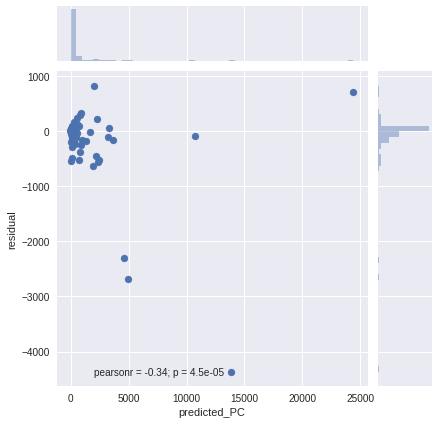

In [86]:
sns.jointplot(y='residual', x='predicted_PC', data=co_data);

In [92]:
metrics.r2_score(co_data['predicted_PC'], co_data['Property\ncrime'])

0.96187228042151152

With the exception of three outliers, the model does remarkably well predicting property crimes in Colorado. It turns out that Denver does better without being marked as a "big city," but with my cutoff at 1,000,000, it wasn't counted this way.
Let's see how our model does on future years in NY.

In [88]:
df_2014 = pd.read_excel('NY_crime_2014.xlsx')

In [89]:
df_2014['no_VC'] = np.where((df_2014['Violent\ncrime'] == 0), 1, 0)
df_2014['VCpc'] = df_2014['Violent\ncrime']/df_2014.Population
df_2014['frthrt_VCpc'] = np.power(df_2014.VCpc, (1/4))
df_2014['is_big'] = np.where((df_2014.Population > 1000000), 1, 0)
df_2014['PCpc'] = df_2014['Property\ncrime']/df_2014.Population
df_2014['cbrt_PCpc'] = np.cbrt(df_2014.PCpc)


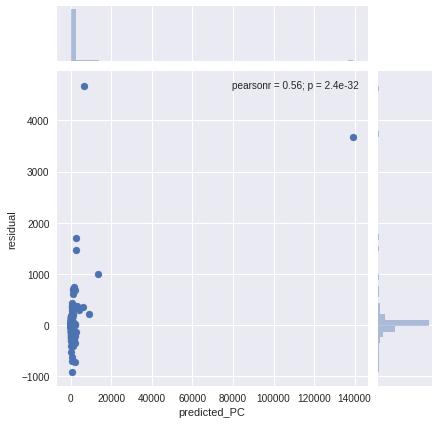

In [90]:
ny=df_2014[['frthrt_VCpc', 'no_VC', 'is_big']]
df_2014['predicted_PCpc'] = np.power(my_reg.predict(exog=ny), 3)
df_2014['predicted_PC'] = df_2014['predicted_PCpc']*df_2014.Population
df_2014['residual']=df_2014['predicted_PC'] - df_2014['Property\ncrime']
df_2014['pc_residual']=df_2014['predicted_PCpc'] - df_2014['PCpc']
sns.jointplot(y='residual', x='predicted_PC', data=df_2014);

In [91]:
metrics.r2_score(df_2014[df_2014['Property\ncrime'].notnull()]['predicted_PC'], df_2014[df_2014['Property\ncrime'].notnull()]['Property\ncrime'])

0.99740989417318993

So, while the residual of these predictions doesn't look very homoscedastic (it's actually just five outliers that make things look bad), the R-squared score is surprisingly high, almost as high as it is on the training data itself!

<H2>Conclusion</H2><br><br>
After evaluating my model, I found that two of my features were statistically insignificant. I iterated my regression by retraining without those two features. The new model was able to predict with a fair amount of accuracy both property crime in Colorado in 2013 and property crime in New York State in 2014.<br><br>
By using the most powerful features, I was able to avoid overfitting and model most of the variance in property crime. This gave me a powerful model. Of course, having violent crime data for the same time period gives us a lot of information about general crime rates, so it's not surprising that modeling this with high accuracy is possible.
